## Using Random Forest to predict the next day regime

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np

ml_df = yf.download('^GSPC', start="1978-01-01", interval="1d")
ml_df

/Users/alden/quantfin/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1978-01-03,0.000000,95.150002,93.489998,93.820000,93.820000,17720000
1978-01-04,0.000000,94.099998,92.570000,93.519997,93.519997,24090000
1978-01-05,0.000000,94.529999,92.510002,92.739998,92.739998,23570000
1978-01-06,0.000000,92.660004,91.050003,91.620003,91.620003,26150000
1978-01-09,0.000000,91.480003,89.970001,90.639999,90.639999,27990000
...,...,...,...,...,...,...
2024-03-04,5130.990234,5149.669922,5127.180176,5130.950195,5130.950195,4758440000
2024-03-05,5110.520020,5114.540039,5056.819824,5078.649902,5078.649902,4418410000
2024-03-06,5108.029785,5127.970215,5092.220215,5104.759766,5104.759766,4559050000


In [40]:
sp500_regimes = pd.read_csv('sp500_regimes.csv')
sp500_regimes.set_index('Date', inplace=True)
sp500_regimes.index = pd.to_datetime(sp500_regimes.index)
ml_df.index = pd.to_datetime(ml_df.index)
data = pd.merge(ml_df.drop(columns=['High','Low','Open','Close','Adj Close']), sp500_regimes, on='Date',how='inner')

In [41]:
data.head()

,Volume,Close,TMA,ATR,low_var,high_var,color,Open,High,Low,LN_return
Date,,,,,,,,,,,
1979-12-24,19150000,107.88,99.679334,0.577426,0.999248,0.000752,blue,107.88,107.66,107.66,0.002348
1979-12-26,24960000,107.78,99.706403,0.553555,0.998880,0.001120,blue,107.78,107.78,107.78,-0.001272
1979-12-27,31410000,107.96,99.733620,0.534877,0.997757,0.002243,blue,107.96,107.96,107.96,0.001325
1979-12-28,34430000,107.84,99.760950,0.514133,0.994670,0.005330,blue,107.84,107.84,107.84,-0.001456
1979-12-31,31530000,107.94,99.788344,0.493427,0.986314,0.013686,blue,107.94,107.94,107.94,0.000583


In [42]:
data['color'] = data['color'].shift(-1)
data.dropna(inplace=True)

In [52]:
X = data.drop(columns=['color'])
y = data['color']

In [53]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
Counter(y_train)

Counter({'blue': 5920, 'red': 939, 'green': 939, 'pink': 727})

The data is skewed, this means classes are unqeually represented. This may affect model's performance. Hence, performing under/oversampling is recommended

## Performing oversampling of the smaller classes

In [54]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Assuming X is your dataset and y is the target variable
oversampler = SMOTE()  # Choose your oversampler: RandomOverSampler, SMOTE, or ADASYN
X_resampled, y_resampled = oversampler.fit_resample(X_train, y_train)

In [55]:
Counter(y_resampled)

Counter({'red': 5920, 'blue': 5920, 'green': 5920, 'pink': 5920})

We can see now that the classes are more equally represented

In [131]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=476, random_state=42)
rf.fit(X_resampled, y_resampled)

RandomForestClassifier(n_estimators=476, random_state=42)

In [132]:
y_pred = rf.predict(X_test)
y_prob_pred = rf.predict_proba(X_test)

## Accuracy of model

In [133]:
from sklearn.metrics import accuracy_score, confusion_matrix

acc_score = accuracy_score(y_test, y_pred)
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(false_positive_rate, true_positive_rate)
acc_score

0.9821763602251408

## Confusion Matrix

Confusion Matrix:
[[1449   15    3    0]
 [   8  233    0    0]
 [   3    0  184    4]
 [   0    3    2  228]]


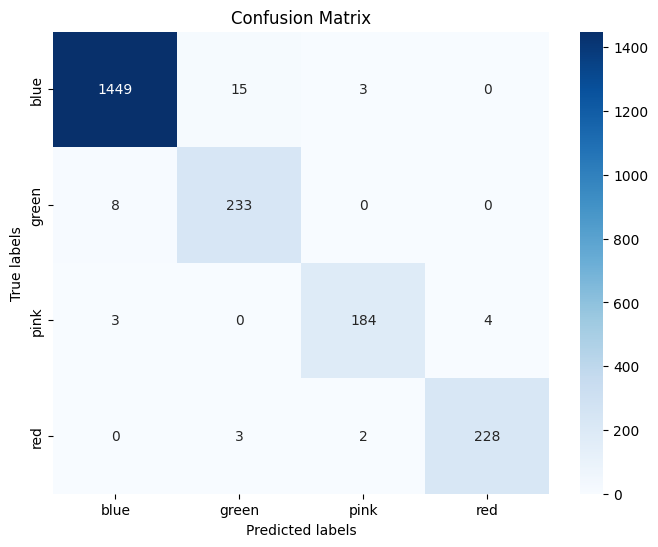

In [134]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = np.unique(y_test)

# Compute the confusion matrix with labels
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Print the confusion matrix with labels
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap with labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

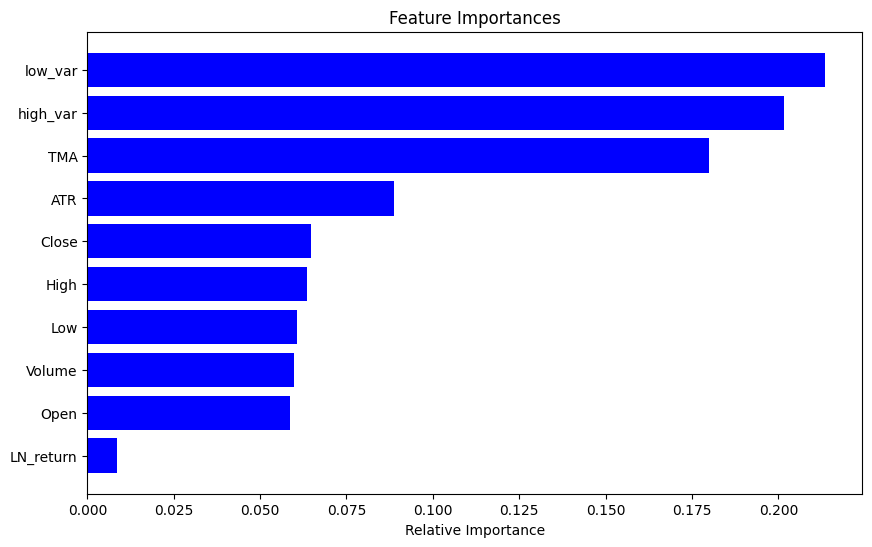

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = rf.feature_importances_

# Get the indices sorted by importance
indices = np.argsort(importances)

# Get the feature names
features = X_train.columns

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [136]:
from sklearn.metrics import f1_score


f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' if you have a multi-class problem

print(f'F1 Score: {f1}')

F1 Score: 0.9822646782981801


In [128]:
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

def rf_cv(n_estimators):
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                   random_state=42)
    return cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy').mean()

param_bounds = {'n_estimators': (10, 500)}

optimizer = BayesianOptimization(f=rf_cv, pbounds=param_bounds, random_state=42)

# Perform the optimization
optimizer.maximize(init_points=10, n_iter=15)

|   iter    |  target   | n_esti... |
-------------------------------------
| 1         | 0.9848    | 193.5     |
| 2         | 0.985     | 475.9     |
| 3         | 0.9848    | 368.7     |
| 4         | 0.9849    | 303.3     |
| 5         | 0.9846    | 86.45     |
| 6         | 0.9846    | 86.44     |
| 7         | 0.983     | 38.46     |
| 8         | 0.9848    | 434.4     |
| 9         | 0.9848    | 304.5     |
| 10        | 0.9847    | 357.0     |
| 11        | 0.9847    | 266.0     |
| 12        | 0.9842    | 142.3     |
| 13        | 0.9849    | 500.0     |
| 14        | 0.9848    | 401.3     |
| 15        | 0.9849    | 226.5     |
| 16        | 0.9849    | 456.7     |
| 17        | 0.9845    | 285.7     |
| 18        | 0.9846    | 245.1     |
| 19        | 0.9848    | 211.2     |
| 20        | 0.9845    | 172.2     |
| 21        | 0.9847    | 111.5     |
| 22        | 0.9847    | 384.7     |
| 23        | 0.9848    | 418.0     |
| 24        | 0.9849    | 487.2     |
| 25        

In [1]:
print(optimizer.max)

NameError: name 'optimizer' is not defined